# Synthesis - Day 2
In today's lecture, we are going to review some of the synthesis techniques, we covered in Intro to Audio Tech I.


In [2]:
import numpy as np
from IPython.display import Audio
#%run hide_toggle.ipynb
from scipy.io.wavfile import read
from scipy import signal
import matplotlib.pyplot as plt

## Frequency Modulation (and Phase Modulation)

Recall that when we write a sinusoid $y(t) = asin(\omega t + \phi)$

This inner component $\Delta t + \phi$ is just time varying phase and can be rewritten as $\phi (t) = \omega t$ such that phase is a function of time given a constant frequency

If we take the derivative of phase with respect to time, we get instantaneous frequency. Below shows when frequency is held constant.

$$\omega _{inst} (t) = \frac {d}{dt} \phi(t) = \frac {d}{dt} \omega t$$


In FM synthesis, we want to change the carrier's instantaneous frequency over time so a better way to think of phase over time and a changing frequency is...

$$\phi(t) = \int \omega _{inst} (\tau)\, d\tau$$

So if we use this definition to get the phase increment of time-varying frequency, we get...

$$\omega _{inst} (t) = \omega _c + \Delta \omega cos(\omega _m t)$$

And plugging in the instantaneous frequency...

$$\phi(t) = \int (\omega_c + \Delta\omega \cos(\omega_m t)) dt$$


Solved to be...
$$\phi (t) = \omega _c t + \frac {\Delta \omega}{\omega _m} sin(\omega _m t)$$

Then, when I plug that in for the phase increment of a sinusoid...

$$y(t) = sin(\omega _c t + \frac {\Delta \omega}{\omega _m} sin(\omega _m t))$$

This can also be re-written as...

$$y(t) = sin(\omega _c t + \beta sin(\omega _m t))$$

Where $\beta$ is the index of modulation! Remember $\omega _m$ is the modulator frequency and $\Delta \omega$ is the frequency deviation (or amplitude of the modulator)

Ok that's a lot of math - what's the point??

Strictly and mathematically speaking, this is frequency modulation. We are changing the instantaneous frequency by adding to the current phase angle then taking then plugging in the increment to the sinusoid.

However, we can achieve the same results by changing the phase angle directly. This is called phase modulation. 

Phase modulation is what many of the "FM synths" actually use because it is easier/"cheaper" to implement. 

In frequency modulation, you change the phase increment (the frequency in this case) before integration -- cos(angle += (incr + change))

In phase modulation, you change the phase increment after integration
- cos((angle += incr) + change)

This matters a lot for digital systems implementing wavetable synthesis where phase is equivalent to stored sample indices.

So what does phase modulation look like?

$$y(t) = sin(\omega _c t + I * m(t))$$

where $ m(t) = sin(\omega _m t)$ and $I = \Delta \theta$ which is proportional to modulator amplitude

So, phase modulation and frequency modulation are essentially equivalent to us for sound synthesis. (only different by some integrating constants and scaled modulation index). Check this link out for more info https://ccrma.stanford.edu/software/snd/snd/fm.html.

We'll implement phase modulation now in Python.

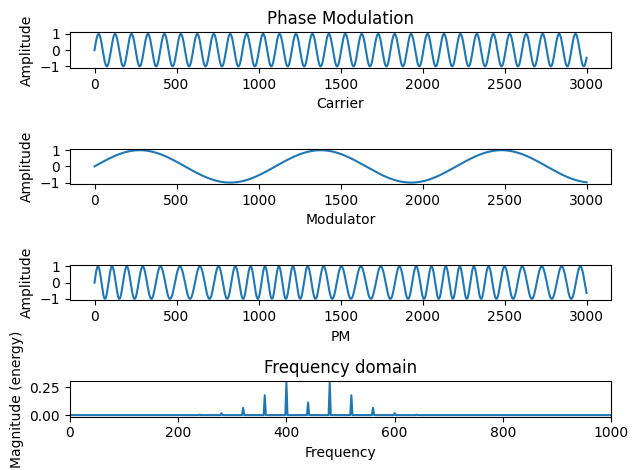

In [9]:
mod_f = 40
car_f = 440
I = 2       # modulation index

fs = 44100
t = np.arange(0, 1, 1/fs)

modulator = np.sin(2*np.pi*mod_f*t)
carrier = np.sin(2*np.pi*car_f*t)

out = np.sin(2*np.pi*car_f*t+I*modulator)
ind = 3000

plt.subplot(4, 1, 1)
plt.title('Phase Modulation')
plt.plot(carrier[:ind]) 
plt.ylabel('Amplitude')
plt.xlabel('Carrier')
plt.subplot(4, 1, 2)
plt.plot(modulator[:ind])
plt.ylabel('Amplitude')
plt.xlabel('Modulator')
plt.subplot(4, 1, 3)
plt.plot(out[:ind])
plt.ylabel('Amplitude')
plt.xlabel('PM')
plt.subplot(4, 1, 4)
plt.magnitude_spectrum(out, Fs=44100)
plt.title("Frequency domain")
plt.xlim([0,1000])
plt.tight_layout()
plt.show()

In [ ]:
Audio(out, rate=fs)

If we implement this explicitly using FM, we have to do the integration

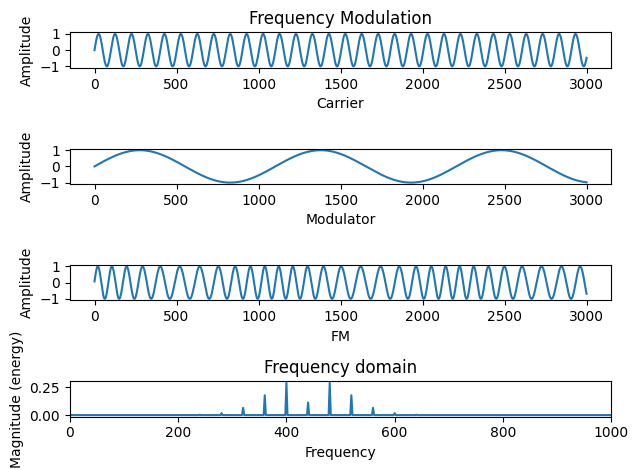

In [10]:
inst_freq = car_f + (I * mod_f * np.cos(2*np.pi * mod_f * t))
phase = 2 * np.pi * np.cumsum(inst_freq) / fs
fm_out = np.sin(phase)

plt.subplot(4, 1, 1)
plt.title('Frequency Modulation')
plt.plot(carrier[:ind]) 
plt.ylabel('Amplitude')
plt.xlabel('Carrier')
plt.subplot(4, 1, 2)
plt.plot(modulator[:ind])
plt.ylabel('Amplitude')
plt.xlabel('Modulator')
plt.subplot(4, 1, 3)
plt.plot(fm_out[:ind])
plt.ylabel('Amplitude')
plt.xlabel('FM')
plt.subplot(4, 1, 4)
plt.magnitude_spectrum(fm_out, Fs=44100)
plt.title("Frequency domain")
plt.xlim([0,1000])
plt.tight_layout()
plt.show()

Let's keep using PM to see how changing the frequency of the modulator and the modulation index change the output.

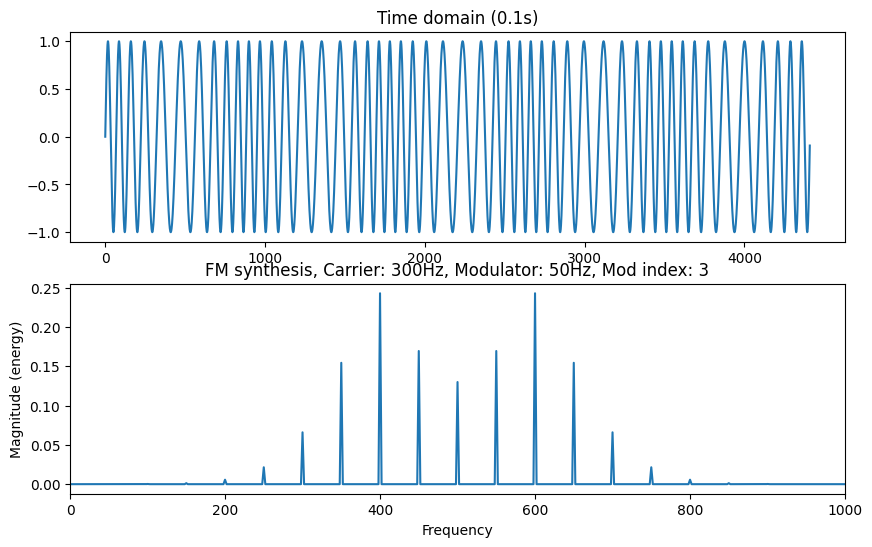

In [17]:
mod_f = 50
car_f = 500
I = 3 # modulation index

fs = 44100
t = np.arange(0, 1, 1/fs)

modulator = np.sin(2*np.pi * mod_f * t)

carrier = np.sin(2*np.pi * car_f * t) # only using this for graphing!

fm = np.sin((2*np.pi * car_f * t) + (I * modulator))

ind = int(fs / mod_f) # for graphing

# FM output
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# plot waveform segment
ax[0].plot(fm[:4410])
ax[0].set_title("Time domain (0.1s)")

# plot spectrum
ax[1].magnitude_spectrum(fm, Fs=fs)
ax[1].set_title("Frequency domain")
ax[1].set_xlim([0,1000])

# set full figure title
plt.title("FM synthesis, Carrier: 300Hz, Modulator: 50Hz, Mod index: " + str(I))

Audio(fm, rate=44100)

Sidebands will appear at carrier_freq $\pm$ multiples of the modulator_freq.

The number of sidebands will increase as the modulation index I increases. The number of sideband pairs is roughly equivalent to I+1.

For FM synthesis, $\beta = \frac {\Delta \omega}{\omega _m}$. This is proportional to I in PM synthesis. So although they are different, they affect the spectrum and number of sidebands the same way. 